# Introduction & Schema Diagram

In [248]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db
%%sql

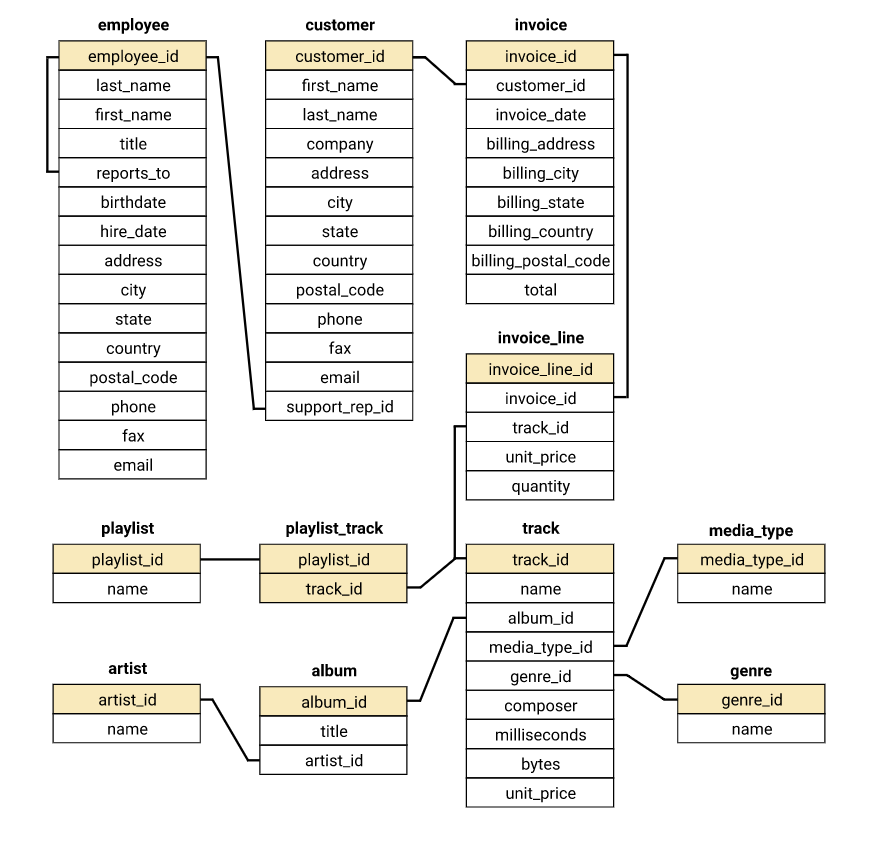

## Data Overview

In [249]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Q1 - Price range of tracks and can a customer purchase the same track more than once?

In [250]:
query = """

SELECT 
    MIN(unit_price),
    MAX(unit_price),
    MIN(quantity),
    MAX(quantity)

FROM
    invoice_line

"""

connection = sqlite3.connect('chinook.db')
q1 = pd.read_sql_query(query,connection)
q1

,MIN(unit_price),MAX(unit_price),MIN(quantity),MAX(quantity)
0,0.99,0.99,1,1


The price of every song is the 0.99 and a customer can not purchase the same song more than once!

## Q2 - 10 most popular genre's in the US

In [258]:
query = """

SELECT 
    g.name genre,
    SUM(il.quantity) usa_tracks_sold

FROM
    track as tr

LEFT JOIN genre as g
    ON tr.genre_id = g.genre_id

JOIN invoice_line as il
    ON tr.track_id = il.track_id

JOIN invoice as i
    ON il.invoice_id = i.invoice_id

JOIN customer as c
    ON i.customer_id = c.customer_id
    
WHERE
    c.country ='USA'
    
GROUP BY
    1
    
ORDER BY
    2 DESC
    
LIMIT 10;
"""

connection = sqlite3.connect('chinook.db')
q2 = pd.read_sql_query(query,connection)
q2

,genre,usa_tracks_sold
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Pop,22
7,Latin,22
8,Hip Hop/Rap,20
9,Jazz,14


## Q3 - What are the most popular genre's in all of our customer base?

In [252]:
query = """

SELECT 
    g.name genre,
    SUM(il.quantity) tracks_sold

FROM
    track as tr

LEFT JOIN genre as g
    ON tr.genre_id = g.genre_id

JOIN invoice_line as il
    ON tr.track_id = il.track_id

JOIN invoice as i
    ON il.invoice_id = i.invoice_id
    
GROUP BY
    1
    
ORDER BY
    2 DESC
    
"""

connection = sqlite3.connect('chinook.db')
q3 = pd.read_sql_query(query,connection)
q3

,genre,tracks_sold
0,Rock,2635
1,Metal,619
2,Alternative & Punk,492
3,Latin,167
4,R&B/Soul,159
5,Blues,124
6,Jazz,121
7,Alternative,117
8,Easy Listening,74
9,Pop,63


## Q4 - Analyzing Sales by Genre

In [261]:
query = """
WITH total_sales AS
    (
    SELECT     
        Count(i.invoice_id)
    
    FROM
        invoice_line il
    
    INNER JOIN invoice i
        ON il.invoice_id = i.invoice_id
    )
    
SELECT
    g.NAME Genre,
    Count(il.quantity) 'Tracks Sold',
    Round(Cast(Count(il.invoice_id)AS FLOAT)/
    (
        SELECT *
        FROM total_sales)*100, 2) 'Percentage of Sales'
FROM
    track t
    
    INNER JOIN genre g
        ON t.genre_id = g.genre_id
        
    INNER JOIN invoice_line il
        ON t.track_id = il.track_id
        
    INNER JOIN invoice i
        ON il.invoice_id = i.invoice_id
        
GROUP BY   
    g.NAME
    
ORDER BY   
    3 DESC
    
LIMIT
    10;
"""

connection = sqlite3.connect('chinook.db')
q4 = pd.read_sql_query(query,connection)
q4

,Genre,Tracks Sold,Percentage of Sales
0,Rock,2635,55.39
1,Metal,619,13.01
2,Alternative & Punk,492,10.34
3,Latin,167,3.51
4,R&B/Soul,159,3.34
5,Blues,124,2.61
6,Jazz,121,2.54
7,Alternative,117,2.46
8,Easy Listening,74,1.56
9,Pop,63,1.32


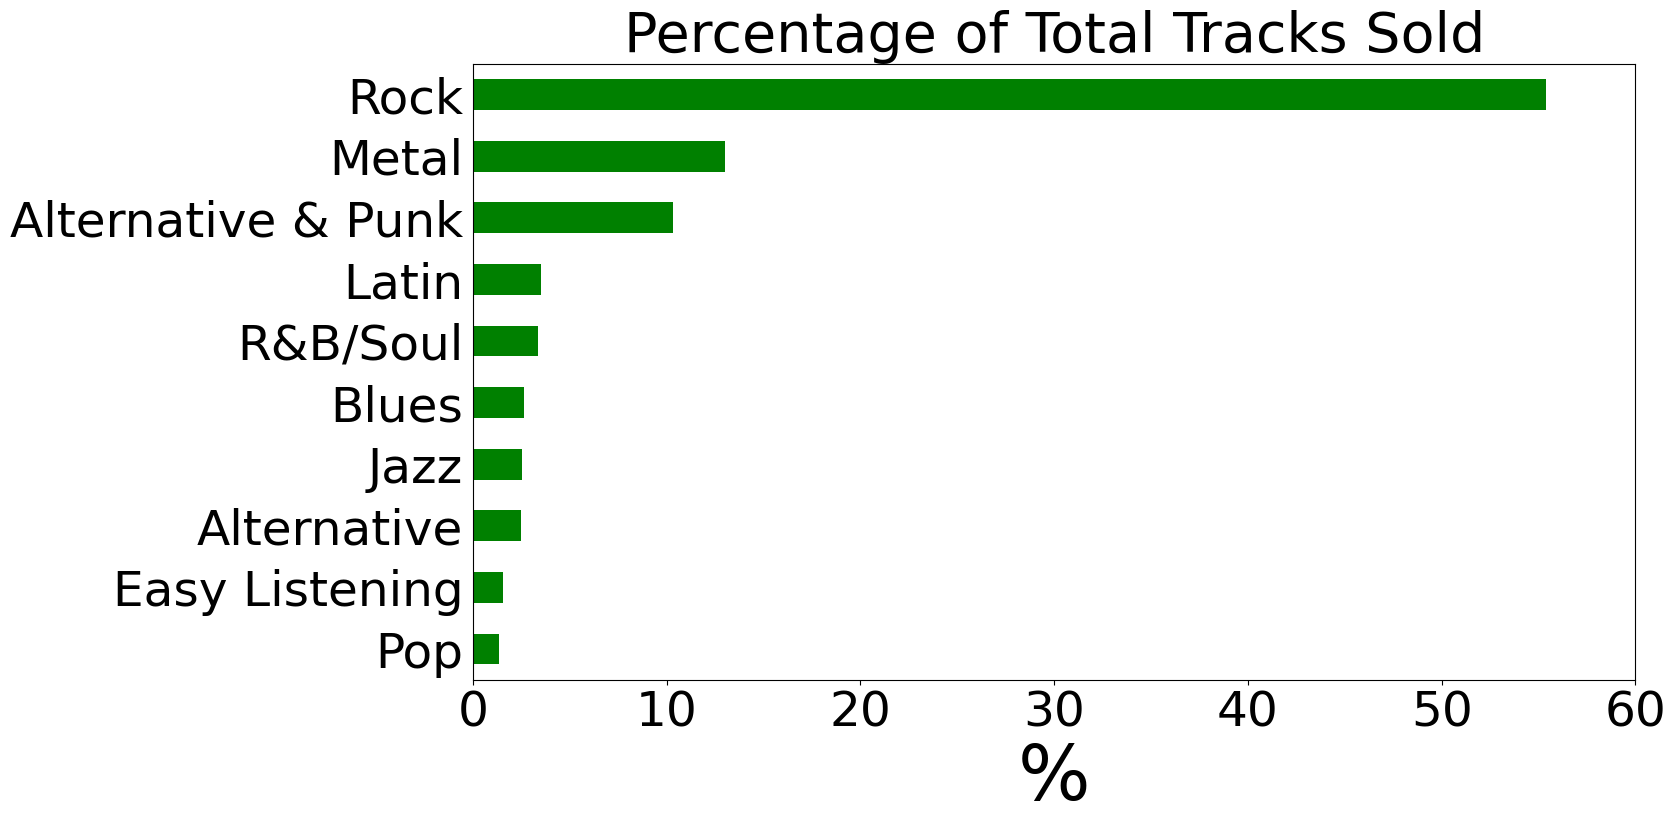

In [262]:
q4 = q4.set_index('Genre', drop=True)

fig, ax = plt.subplots(figsize = (15,8))
q4['Percentage of Sales'].sort_values().plot.barh(color = 'g', xlim = (0,60), rot=0)
ax.set_title('Percentage of Total Tracks Sold', fontsize = 40)
ax.set_ylabel(None)
ax.set_xlabel('%', fontsize = 55)
ax.tick_params(axis='both', labelsize = 35, left = False)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

The three most popular genre's in the USA are Rock, Alternative & Punk, and Metal

## Q5 - Analyzing Employee Sales Performance

In [263]:
query =""" 
WITH summary_agents AS 
(
    SELECT
        e.first_name || " " || e.last_name employee,
        e.birthdate,
        e.hire_date,
        COUNT(c.customer_id) customers,
        ROUND( SUM(i.total), 0 ) total_sales 
      
    FROM
        employee e
      
    LEFT JOIN customer c 
        ON e.employee_id = c.support_rep_id
        
    INNER JOIN invoice i 
        ON c.customer_id = i.customer_id
        
    WHERE
        e.title = "Sales Support Agent"
        
    GROUP BY
        1
        
    ORDER BY
        5 DESC
)

SELECT
    employee,
    birthdate,
    hire_date,
    customers,
    ROUND( customers * 100.0 / ( 
        SELECT
            SUM(customers) 
        FROM
          summary_agents ), 0 ) pct_customers,
          
    total_sales,
    
    ROUND( total_sales * 100.0 / ( 
        SELECT
            SUM(total_sales) 
        FROM
            summary_agents ), 0 ) pct_sales 
FROM
    summary_agents;

"""
connection = sqlite3.connect('chinook.db')
q5 = pd.read_sql_query(query,connection)
q5

,employee,birthdate,hire_date,customers,pct_customers,total_sales,pct_sales
0,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,212,35.0,1732.0,37.0
1,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,214,35.0,1584.0,34.0
2,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,188,31.0,1394.0,30.0


There are 8 employees but only 3 have sales, these are the sales support agents Jane P, Margaret P, and Steve J.

## Q6 - Most popular artist by country

In [296]:
query ="""
SELECT 
    ar.name,
    i.billing_country,
    SUM(il.quantity) sold_tracks
       
FROM   
    track AS tr

RIGHT JOIN invoice_line AS il
    ON tr.track_id = il.track_id
    
JOIN invoice AS i
    ON il.invoice_id = i.invoice_id
    
JOIN album AS al
    ON tr.album_id = al.album_id
    
JOIN artist AS ar
    ON al.artist_id = ar.artist_id
    
WHERE  
    i.billing_country IS NOT NULL
    
GROUP BY 
    2
    
ORDER BY 
    3 DESC; 
    
"""

connection = sqlite3.connect('chinook.db')
q6 = pd.read_sql_query(query,connection)
q6

,name,billing_country,sold_tracks
0,AC/DC,USA,1051
1,AC/DC,Canada,541
2,AC/DC,Brazil,432
3,AC/DC,France,393
4,AC/DC,Germany,338
5,AC/DC,Czech Republic,276
6,AC/DC,United Kingdom,248
7,AC/DC,Portugal,187
8,AC/DC,India,185
9,AC/DC,Ireland,116


AC/DC is very popular!

## Q7 - Analyzing Sales by Country

In [264]:
query = """
WITH countries AS 
(
    SELECT 
        CASE 
            WHEN 
            (
            SELECT 
                count(*)
        
            FROM 
                customer
            
            WHERE 
                country = c.country
                
            ) = 1 THEN "Other" ELSE c.country END AS country, 
        COUNT(DISTINCT c.customer_id) customers, 
        SUM(i.total) total_sales, 
        SUM(i.total)/ COUNT(DISTINCT i.invoice_id) average_order, 
        SUM(i.total)/ COUNT(DISTINCT c.customer_id) customer_lifetime_value 
        
    FROM 
        invoice i
        
    INNER JOIN customer c 
        ON c.customer_id = i.customer_id
        
    GROUP BY 
        1
) 
SELECT 
  countries.*, 
  CASE WHEN country = "Other" THEN 1 ELSE 0 END AS sort 
  
FROM 
  countries
  
ORDER BY 
  sort ASC, 
  3 DESC

"""

connection = sqlite3.connect('chinook.db')
q7 = pd.read_sql_query(query,connection)
q7


,country,customers,total_sales,average_order,customer_lifetime_value,sort
0,USA,13,1040.49,7.942672,80.037692,0
1,Canada,8,535.59,7.047237,66.948750,0
2,Brazil,5,427.68,7.011148,85.536000,0
3,France,5,389.07,7.781400,77.814000,0
4,Germany,4,334.62,8.161463,83.655000,0
5,Czech Republic,2,273.24,9.108000,136.620000,0
6,United Kingdom,3,245.52,8.768571,81.840000,0
7,Portugal,2,185.13,6.383793,92.565000,0
8,India,2,183.15,8.721429,91.575000,0
9,Other,15,1094.94,7.448571,72.996000,1


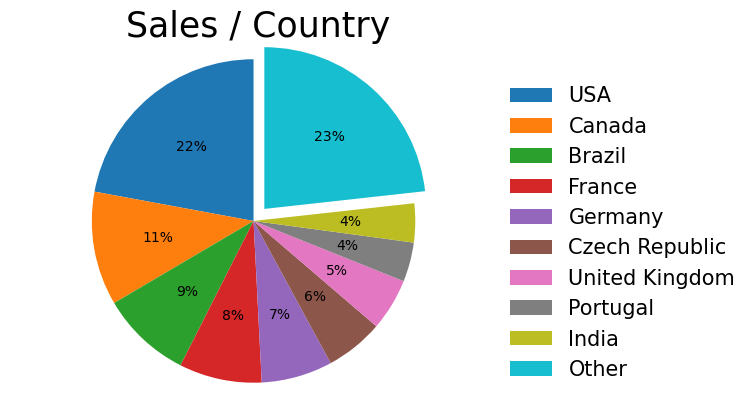

In [265]:
labels = q7.country
sizes = q7.total_sales

fig, ax = plt.subplots()
ax.pie(sizes,explode = (0,0,0,0,0,0,0,0,0,0.1), autopct='%1.0f%%', startangle = 90)
ax.axis('equal')
ax.set_title('Sales / Country', fontsize = 25, y = .96)
ax.legend(labels = labels, fontsize = 15, bbox_to_anchor = (1.5, .9), frameon = False)
plt.show()

The countries included as "Other" are those that have only have 1 customer (15 different countries). These sales equate to 23% of our total sales!

## Q8 - Albums vs Individual Tracks

In [266]:
query = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
         
     FROM
         invoice_line il
         
     GROUP BY 
         1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / 
    (
        SELECT
            COUNT(*)
            
        FROM
            invoice
    ) percent
    
FROM
    (
    SELECT
        ifs.*,
        CASE 
            WHEN

            (
            SELECT 
                t.track_id
            
            FROM 
                track t
            
            WHERE 
                t.album_id =
                (
                SELECT 
                    t2.album_id
                
                FROM 
                    track t2
                
                WHERE 
                    t2.track_id = ifs.first_track_id
                ) 

            EXCEPT
                SELECT
                    il2.track_id 
            
                FROM 
                    invoice_line il2
                
                WHERE
                    il2.invoice_id = ifs.invoice_id
                
            ) IS NULL
            
            AND
                (
                SELECT 
                    il2.track_id
                      
                FROM 
                    invoice_line il2
                    
                WHERE 
                    il2.invoice_id = ifs.invoice_id

                EXCEPT 
                    SELECT 
                        t.track_id
                        
                    FROM
                        track t
                        
                    WHERE 
                        t.album_id =
                        (
                        SELECT
                            t2.album_id
                            
                        FROM
                            track t2
                            
                        WHERE 
                            t2.track_id = ifs.first_track_id
                        ) 
                 ) IS NULL
                 
             THEN
                 "yes"
                 
             ELSE 
                 "no"
                 
         END AS 
             "album_purchase"
         
     FROM 
         invoice_first_track ifs
    )
GROUP BY 
    album_purchase;
"""

connection = sqlite3.connect('chinook.db')
q8 = pd.read_sql_query(query,connection)
q8

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


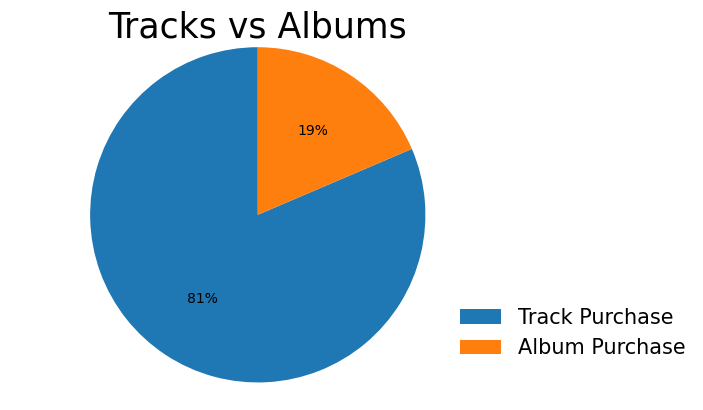

In [267]:
labels = ['Track Purchase', 'Album Purchase']
sizes = q8['percent']

fig, ax = plt.subplots()
ax.pie(sizes, autopct='%1.0f%%', startangle = 90)
ax.axis('equal')
ax.set_title('Tracks vs Albums', fontsize = 25, y = .96)
ax.legend(labels = labels, fontsize = 15, bbox_to_anchor = (1.4, 0.3), frameon = False)
plt.show()

## Q9 - Which artist is used in the most playlists for each genre?

In [268]:
query ="""

SELECT 
    ar.name 'artist name',
    COUNT(DISTINCT(plt.playlist_id)) '# of playlists',
    g.name
    
FROM
    artist as ar
    
INNER JOIN album as al 
    ON ar.artist_id = al.artist_id
    
INNER JOIN track as tr
    ON al.album_id = tr.album_id

INNER JOIN playlist_track as plt 
    ON plt.track_id = tr.track_id

JOIN genre as g
    ON tr.genre_id = g.genre_id

GROUP BY
    3
    
ORDER BY
    2 DESC
    
"""

connection = sqlite3.connect('chinook.db')
q9 = pd.read_sql_query(query,connection)
q9

,artist name,# of playlists,name
0,Aaron Copland & London Symphony Orchestra,7,Classical
1,Gilberto Gil,5,Soundtrack
2,AC/DC,5,Rock
3,"Sir Georg Solti, Sumi Jo & Wiener Philharmoniker",5,Opera
4,Audioslave,5,Alternative
5,Apocalyptica,4,Metal
6,Marcos Valle,4,Latin
7,Aaron Goldberg,4,Jazz
8,Habib Koité and Bamada,3,World
9,BackBeat,3,Rock And Roll


## Q10 - How many tracks have been purchased vs not purchased?

In [279]:
query = """
WITH all_vs_sold AS 
    (SELECT 
        COUNT(DISTINCT(tr.track_id)) all_tracks,
        COUNT(DISTINCT(il.track_id)) sold_tracks
        
    FROM 
        track as tr
        
    LEFT JOIN invoice_line as il 
        ON tr.track_id = il.track_id
    )

SELECT 
    all_vs_sold.*,
    ROUND(sold_tracks * 100.0 / all_tracks, 0) '%_sold'
    
FROM
    all_vs_sold;
"""

connection = sqlite3.connect('chinook.db')
q10 = pd.read_sql_query(query,connection)
q10

,all_tracks,sold_tracks,%_sold
0,3503,1806,52.0


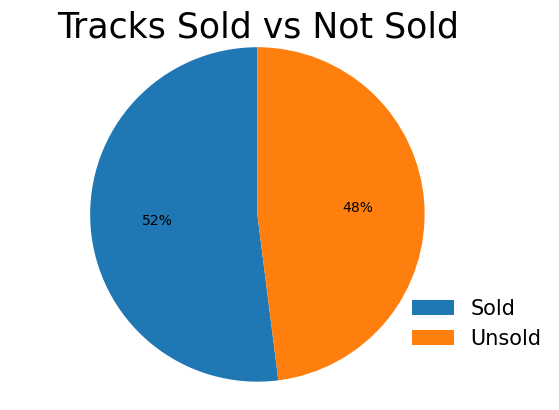

In [280]:
labels = ['Sold', 'Unsold']
sizes = [52, 48]

fig, ax = plt.subplots()
ax.pie(sizes, autopct='%1.0f%%', startangle = 90)
ax.axis('equal')
ax.set_title('Tracks Sold vs Not Sold', fontsize = 25, y = .96)
ax.legend(labels = labels, fontsize = 15, bbox_to_anchor = (.773, .325), frameon = False)
plt.show()

## Q11 - Protected vs Non-protected media type

In [278]:
query ="""
SELECT
    mt.name,
    SUM((il.quantity)) sold_tracks
        
FROM 
    track as tr
        
RIGHT JOIN invoice_line as il 
    ON tr.track_id = il.track_id
        
JOIN media_type as mt
    ON tr.media_type_id = mt.media_type_id
        
GROUP BY
    1
    
ORDER BY
    2 DESC;

"""

connection = sqlite3.connect('chinook.db')
q11 = pd.read_sql_query(query,connection)
q11

,name,sold_tracks
0,MPEG audio file,4259
1,Protected AAC audio file,439
2,Purchased AAC audio file,35
3,AAC audio file,21
4,Protected MPEG-4 video file,3


It should be noted that 'Purchased AAC Audio file' is a type of protected media type that was used in the iTunes store prior to April 2009. Nevertheless unprotected files are the clear prefrence.

# Q12 - Most popular artist for each genre

In [274]:
query = """
SELECT 
    ar.name,
    g.name genre,
    SUM(il.quantity) sold_tracks

FROM   
    track AS tr

RIGHT JOIN invoice_line AS il
    ON tr.track_id = il.track_id

JOIN genre as g
    ON tr.genre_id = g.genre_id

JOIN album AS al
    ON tr.album_id = al.album_id

JOIN artist AS ar
    ON al.artist_id = ar.artist_id

GROUP BY 
    2

ORDER BY 
    3 DESC;

"""

connection = sqlite3.connect('chinook.db')
q12 = pd.read_sql_query(query,connection)
q12

,name,genre,sold_tracks
0,AC/DC,Rock,2635
1,Apocalyptica,Metal,619
2,Audioslave,Alternative & Punk,492
3,Caetano Veloso,Latin,167
4,James Brown,R&B/Soul,159
5,Buddy Guy,Blues,124
6,Antônio Carlos Jobim,Jazz,121
7,Cake,Alternative,117
8,Frank Sinatra,Easy Listening,74
9,U2,Pop,63
